In [1]:
import os
import warnings
from pathlib import Path

import numpy as np
from qkeras import QGRU, QLSTM, QSimpleRNN
from qkeras.qconv2d_batchnorm import QConv2DBatchnorm
from qkeras.qconvolutional import QDepthwiseConv2D, QSeparableConv1D, QSeparableConv2D
from qkeras.qlayers import QActivation, QDense
from qkeras.quantizers import (
    binary,
    quantized_bits,
    quantized_po2,
    quantized_relu,
    quantized_sigmoid,
    quantized_tanh,
    ternary,
)
from qkeras.utils import _add_supported_quantized_objects
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.utils import to_categorical

import hls4ml
print(hls4ml.__version__)

backend = 'Vitis'
saved_model_dir = f'exp_16bit_qnn'
import shutil  # 添加這行
if os.path.exists(saved_model_dir):
    shutil.rmtree(saved_model_dir)

if not os.path.exists(saved_model_dir):
    os.makedirs(saved_model_dir)

2025-02-20 10:31:21.883604: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 10:31:21.885308: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 10:31:21.903881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 10:31:21.903899: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 10:31:21.903918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'
1.1.0.dev15+g3ca0050d.d20250127


/data/robin/git/hls4ml/hls4ml/converters/__init__.py:28: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
# 數據加載函數
def load_emg_data(data_dir='./EMG/processed/'):
    X = []
    y = []
    
    for class_id in range(8):
        file_path = os.path.join(data_dir, f'g_id_{class_id}.npy')
        if os.path.exists(file_path):
            class_data = np.load(file_path)
            # 在這裡調整數據形狀
            if class_data.shape[1] == 8:  # 如果第二維是特徵數
                class_data = np.transpose(class_data, (0, 2, 1))
            X.append(class_data)
            y.append(np.full(len(class_data), class_id))
    
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    
    return X, y

# 加載數據
X, y = load_emg_data()
print(X.shape)
print(y.shape)

(400, 100, 8)
(400,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 將標籤轉換為one-hot編碼
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [5]:
"""
QLSTM(
        4,
        input_shape=(5, 2),
        kernel_quantizer='quantized_bits(8,0, alpha=1)',
        recurrent_quantizer='quantized_bits(8,0, alpha=1)',
        bias_quantizer='quantized_bits(8,0, alpha=1)',
        state_quantizer='quantized_bits(8,0, alpha=1)',
        activation='tanh',
        recurrent_activation='sigmoid',
    )
"""
# 建立LSTM模型
model = Sequential([
    QLSTM(64, input_shape=(100, 8), return_sequences=False,
          kernel_quantizer='quantized_bits(16,6, alpha=1)',
          recurrent_quantizer='quantized_bits(16,6, alpha=1)',
          bias_quantizer='quantized_bits(16,6, alpha=1)',
          state_quantizer='quantized_bits(16,6, alpha=1)',
          activation='tanh',
          recurrent_activation='sigmoid',
          ),
    QDense(8,
          kernel_quantizer='quantized_bits(16,6, alpha=1)',
          bias_quantizer='quantized_bits(16,6, alpha=1)',
          ),
    Activation(input_shape=(8,), activation='softmax')
    
])
# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# 訓練模型
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 保存模型
model.save(f'{saved_model_dir}/keras_lstm.keras')

2025-02-20 10:31:32.744445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-20 10:31:32.744592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-20 10:31:32.760237: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

Epoch 1/10
10/10 [==============================] - 1s 36ms/step - loss: 1.9142 - accuracy: 0.3375 - val_loss: 1.6300 - val_accuracy: 0.6375
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 1.4429 - accuracy: 0.7531 - val_loss: 1.2402 - val_accuracy: 0.7250
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 1.0682 - accuracy: 0.8188 - val_loss: 0.9506 - val_accuracy: 0.7625
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.7765 - accuracy: 0.8875 - val_loss: 0.6679 - val_accuracy: 0.9125
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 0.5072 - accuracy: 0.9656 - val_loss: 0.4187 - val_accuracy: 0.9500
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.3437 - accuracy: 0.9563 - val_loss: 0.2946 - val_accuracy: 0.9500
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 0.1973 - accuracy: 0.9812 - val_loss: 0.3010 - val_accuracy: 0.9375
Epoch 8/10
10

/home/robin/miniconda3/envs/hls4ml_pr_1171/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [6]:
# # define a qlstm model
qlstm_model = Sequential([
    QLSTM(64, input_shape=(100, 8), return_sequences=False,
          kernel_quantizer='quantized_bits(16,6, alpha=1)',
          recurrent_quantizer='quantized_bits(16,6, alpha=1)',
          bias_quantizer='quantized_bits(16,6, alpha=1)',
          state_quantizer='quantized_bits(16,6, alpha=1)',
          activation='tanh',
          recurrent_activation='sigmoid',
          ),
    QDense(8,
          kernel_quantizer='quantized_bits(16,6, alpha=1)',
          bias_quantizer='quantized_bits(16,6, alpha=1)',
          ),
])
# load the model parameters
qlstm_model.load_weights(f'{saved_model_dir}/keras_lstm.keras')

softmax_8 = Sequential([Activation(input_shape=(8,), activation='softmax')])

In [7]:
import hls4ml

qlstm_config = hls4ml.utils.config_from_keras_model(
    qlstm_model, granularity='name', default_precision="ap_fixed<16,7>", backend='Vitis'
)

print(qlstm_config)
output_dir = f'{saved_model_dir}/qlstm_hlsprj'
hls_qlstm_model = hls4ml.converters.convert_from_keras_model(
    qlstm_model, hls_config=qlstm_config, output_dir=output_dir, backend='Vitis',
    part='xcu50-fsvh2104-2-e', io_type='io_parallel')
hls_qlstm_model.compile()

softmax_8_config = hls4ml.utils.config_from_keras_model(
    softmax_8, granularity='name', default_precision="ap_fixed<16,7>", backend='Vitis'
)

print(softmax_8_config)
softmax_8_output_dir = f'{saved_model_dir}/softmax_hlsprj'
hls_softmax_8_model = hls4ml.converters.convert_from_keras_model(
    softmax_8, hls_config=softmax_8_config, output_dir=softmax_8_output_dir, backend='Vitis',
    part='xcu50-fsvh2104-2-e', io_type='io_parallel')
hls_softmax_8_model.compile()

Interpreting Sequential
Topology:
Layer name: qlstm_1_input, layer type: InputLayer, input shapes: [[None, 100, 8]], output shape: [None, 100, 8]
Layer name: qlstm_1, layer type: QLSTM, input shapes: [[None, 100, 8]], output shape: [None, 64]
Layer name: q_dense_1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 8]
{'Model': {'Precision': {'default': 'ap_fixed<16,7>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}, 'LayerName': {'qlstm_1_input': {'Trace': False, 'Precision': {'result': 'auto'}}, 'qlstm_1': {'Trace': False, 'Precision': {'result': 'auto', 'weight': 'fixed<16,7,TRN,WRAP,0>', 'bias': 'fixed<16,7,TRN,WRAP,0>', 'recurrent_weight': 'fixed<16,7,TRN,WRAP,0>', 'recurrent_bias': 'auto', 'accum': 'auto', 'table': 'fixed<18,8,TRN,WRAP,0>'}, 'Direction': 'forward', 'ReuseFactor': 1, 'RecurrentReuseFactor': 1, 'Static': True, 'TableSize': 1024}, 'qlstm_1_tanh': {'Trace': False, 'Precision': {'result': 'auto', 'table': '

In [ ]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_softmax_8_model.predict(hls_qlstm_model.predict(np.ascontiguousarray(X_test)))

print("Accuracy of quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy of hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

3/3 [==============================] - 0s 5ms/step
[80]
[80]
Accuracy pruned, quantized: 0.875
Accuracy hls4ml: 0.9125


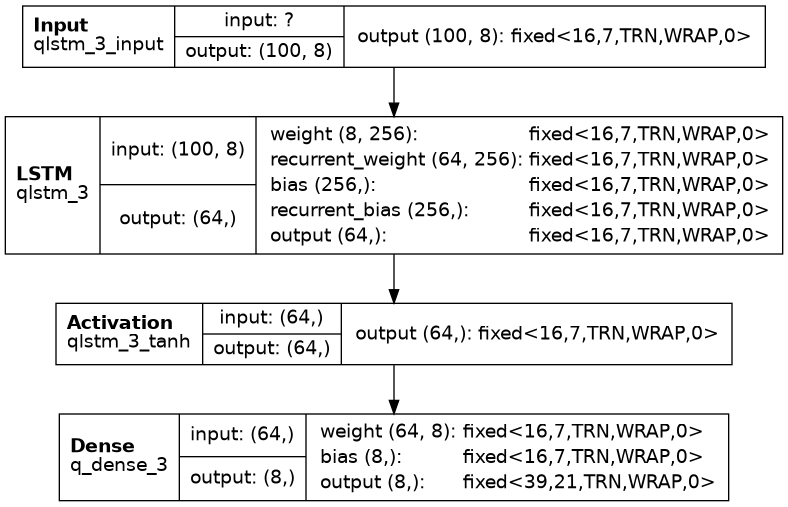

In [13]:
hls4ml.utils.plot_model(hls_qlstm_model, show_shapes=True, show_precision=True, to_file=None)

In [14]:
hls_qlstm_model.build(csim=False, vsynth=True)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.2 (64-bit)
  **** SW Build 4023990 on Oct 11 2023
  **** IP Build 4028589 on Sat Oct 14 00:45:43 MDT 2023
  **** SharedData Build 4025554 on Tue Oct 10 17:18:54 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /data/robin/Xilinx/Vitis_HLS/2023.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/data/robin/Xilinx/Vitis_HLS/2023.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'robin' on host 'AISRV4090-01' (Linux_x86_64 version 5.14.0-503.16.1.el9_5.x86_64) on Fri Jan 24 01:58:42 CST 2025
INFO: [HLS 200-10] In directory '/data/robin/git/qkeras_hl4ml/lstm/emg_dataset/hls4mlprj_keras_lstm_Vitis'
INFO: [HLS 200-2053] The vitis_hls executable is being deprecated. Consider using vitis-run --mode hls --tcl
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myprojec

In [ ]:
hls_softmax_8_model.build(csim=False, vsynth=True)